# ASR Tensorflow Testbed

In [108]:
import tensorflow as tf
import numpy as np

def sliding_window(inp, frame_length, frame_shift, max_number_frames=None, padding="VALID", name="sliding_window"):
    '''
    Runs a sliding window across a signal (of audio data, for example).
    Params:
      - inp:  A [batch_size, channels, signal_length] tensor
      - frame_length:  The length of each frame in number of samples
      - frame_shift:  How many samples to shift the window
      - padding:  How to pad the ends, can be "SAME" or "VALID"
    Returns:
      - A [batch_size, channels, signal_length // frame_shift (approx, depending on padding), frame_length] tensor of frames

    Example:

    ```
    p = tf.placeholder(tf.float32, [None, 2, None])
    patches = sliding_window(p, 5, 3, padding="VALID")

    with tf.Session() as sess:
        # Make 3, 2-channel signals
        a1 = np.vstack([np.arange(15), np.arange(15, 15 + 15)])
        a2 = np.vstack([np.arange(30, 30 + 15), np.arange(45, 45 + 15)])
        a3 = np.vstack([np.arange(60, 60 + 15), np.arange(75, 75 + 15)])
        # Stack the batch:
        batch = np.vstack([np.expand_dims(a1, 0), np.expand_dims(a2, 0), np.expand_dims(a3, 0)])
        x = sess.run(patches, feed_dict={
            p: batch 
        })
        print(x.shape)
        print(x)
    ```

    Prints:
    (3, 2, 4, 5)
    [[[[  0.   1.   2.   3.   4.]
       [  3.   4.   5.   6.   7.]
       [  6.   7.   8.   9.  10.]
       [  9.  10.  11.  12.  13.]]

      [[ 15.  16.  17.  18.  19.]
       [ 18.  19.  20.  21.  22.]
       [ 21.  22.  23.  24.  25.]
       [ 24.  25.  26.  27.  28.]]]


     [[[ 30.  31.  32.  33.  34.]
       [ 33.  34.  35.  36.  37.]
       [ 36.  37.  38.  39.  40.]
       [ 39.  40.  41.  42.  43.]]

      [[ 45.  46.  47.  48.  49.]
       [ 48.  49.  50.  51.  52.]
       [ 51.  52.  53.  54.  55.]
       [ 54.  55.  56.  57.  58.]]]


     [[[ 60.  61.  62.  63.  64.]
       [ 63.  64.  65.  66.  67.]
       [ 66.  67.  68.  69.  70.]
       [ 69.  70.  71.  72.  73.]]

      [[ 75.  76.  77.  78.  79.]
       [ 78.  79.  80.  81.  82.]
       [ 81.  82.  83.  84.  85.]
       [ 84.  85.  86.  87.  88.]]]]
    '''
    assert(len(inp.shape) == 3)  # [batch_size, channels, frame length]
    with tf.name_scope(name):
        expanded = tf.expand_dims(inp, 3)
        frames = tf.extract_image_patches(expanded, [1, 1, frame_length, 1], [1, 1, frame_shift, 1], [1, 1, 1, 1], padding)
        if max_number_frames != None:
            frames = tf.slice(frames, tf.stack([0, 0, 0, 0]), tf.stack([-1, -1, tf.cast(max_number_frames, tf.int32), -1]))
        frames = tf.identity(frames, name=name)
    return frames

class UnsupportedWindowTypeException(Exception):
    pass

def magnitude(complex_spec, name=None):
    return tf.abs(complex_spec, name=name)

def energy(complex_spec, name=None):
    return tf.power(magnitude(complex_spec), 2, name=name)

def decibels(complex_spec):
    return 20 * tf.log(magnitude(complex_spec)) / np.log(10)

def timeseries_to_spec(frames, N, window_type='hamming', N_fft=None, zero_pad=True, gpu=False, name="spec"):
    '''
    Converts a timeseries to a spectrogram (preprocessing by removing the DC offset, zero padding,
        and applying a window function)
    Params:
        - frames: A [batch_size, channels, frame count, frame_length] tensor
        - window_type: the type of window (the same types supported as get_window)
        - zero_pad: whether to zero_pad the frames to the next highest order of 2 for more efficient FFT
        - remove_dc: whether to remove the DC offset (mean) of each frame
    Returns: A [batch_size, frame_count, FFT bin count] tensor.  FFT bin count is the next highest order of 2
        above the frame_length (divided by 2) if zero_pad is True and is the frame_length (divided by 2) if
        zero_pad is False.  The division by 2 is to get to the Nyquist frequency.
    Example:

    import scipy.io.wavfile as wavfile

    def spec_generator(audio, sample_rate):
        frame_length = int(0.025 * sample_rate)
        frame_shift = int(0.015 * sample_rate)
        frames = sliding_window(audio, frame_length, frame_shift, padding="VALID")
        spec = timeseries_to_spec(frames)
        spec = decibels(spec)
        return spec

    with tf.Session() as sess:
        sr, audio = wavfile.read("/data/sls/u/urop/kkleidal/three.wav")
        p = tf.placeholder(tf.float32, [None, 2, None])
        spec = spec_generator(p, sr)
        audio_float = audio.astype(np.float32) / np.iinfo(np.int16).max
        audio_float = np.expand_dims(audio_float.T, 0)
        s = sess.run(spec, feed_dict={
            p: audio_float,
        })
        f = draw_spectrogram(np.squeeze(s, axis=0), sr)
        plt.show(f)
    '''
    with tf.name_scope(name):
        if zero_pad:
            if N_fft is None:
                N_fft = np.power(2, np.ceil(np.log(np.float64(N)) / np.log(2)))
            print(N_fft, N)
            if N_fft > N:
                frames = tf.pad(frames, [[0, 0], [0, 0], [0, 0], [0, N_fft - N]], "CONSTANT")
            elif N_fft < N:
                frames = tf.transpose(tf.image.resize_images(tf.transpose(frames, [0, 2, 3, 1]), [tf.shape(frames)[2], N_fft]), [0, 3, 1, 2])
            print(frames)
        window = tf.constant(get_window(window_type, N, N_t=N_fft).astype(np.float32), name="window")
        frames = frames * window
        # if gpu:
        complex_frames = tf.complex(frames, tf.zeros(tf.shape(frames)))
        spec = tf.fft(complex_frames)
        # else:
        #     def rfft(x):
        #         return np.fft.rfft(x).astype(np.complex64)
        #     spec, = tf.py_func(rfft, [frames], [tf.complex65])
        complex_spec = tf.slice(spec, tf.stack([0, 0, 0, 0]), tf.stack([-1, -1, -1, N_fft // 2 + 1]), name=name)
        mag_spec = magnitude(complex_spec, name="magnitude_spec")
        energy_spec = magnitude(complex_spec, name="energy_spec")
        return N_fft, mag_spec, energy_spec

def apply_filterbank(spec, filter_bank, name="apply_filterbank"):
    '''
    Params:
      - spec: [batch_size, channels, frames, FFT bins] tensor, the magnitude spectrum
      - filter_bank: [FFT bins, number filters] tensor, the filter bank 
    Returns:
      - [batch_size, channels, frames, number filters] tensor, the filter bank features

    Example:

    import scipy.io.wavfile as wavfile

    def spec_generator(audio, sample_rate):
        frame_length = int(0.025 * sample_rate)
        frame_shift = int(0.015 * sample_rate)
        frames = sliding_window(audio, frame_length, frame_shift, padding="VALID")
        spec = timeseries_to_spec(frames)
        spec = decibels(spec)
        fbank = mel_filterbank(tf.shape(spec)[-1], sample_rate)
        fbank_features = apply_filterbank(spec, fbank)
        return fbank_features

    with tf.Session() as sess:
        sr, audio = wavfile.read("/data/sls/u/urop/kkleidal/three.wav")
        p = tf.placeholder(tf.float32, [None, 2, None])
        fbank = spec_generator(p, sr)
        audio_float = audio.astype(np.float32) / np.iinfo(np.int16).max
        audio_float = np.expand_dims(audio_float.T, 0)
        fbank = sess.run([fbank], feed_dict={
            p: audio_float,
        })
        f = draw_spectrogram(np.squeeze(fbank, axis=0))
        plt.show(f)
    '''
    with tf.name_scope(name):
        shape = tf.shape(spec)
        two_d = tf.reshape(spec, [-1, shape[-1]])
        feats = tf.matmul(two_d, filter_bank)
        return tf.identity(tf.reshape(feats, [shape[0], shape[1], shape[2], -1]), name)

## UTILITY:
def plot_spec(spec, ax=None, sample_rate=None, cmap="Spectral", title="Spectrogram"):
    if ax is None:
        pltax = plt.gca()
    spec = np.transpose(np.squeeze(np.squeeze(spec, 0), 0), [1, 0])
    c = pltax.imshow(spec, cmap="Spectral", origin='lower', interpolation='nearest', aspect='auto')
    if sample_rate is not None:
        newlabels = (pltax.get_yticks() / float(2 * (spec.shape[0] - 1)) * sample_rate).tolist()
        pltax.set_yticklabels(newlabels)
        pltax.set_ylabel("Frequency (Hz)")
    else:
        pltax.set_ylabel("FFT Bin")
    pltax.set_xlabel("Frame Number")
    pltax.set_title(title)
    if ax is None:
        plt.colorbar(c)
        
def get_window(window_type, N, N_t=None):
    '''
    Gets a window function to be applied to a timeseries via component-wise multiplication
    Params:
        - window_type: the type of window ('none', 'hamming', and 'hanning' supported)
        - N: the number of frames in the output
        - N_t: the number of frames in the input (only the first N of which will be used)
    Returns:
        - The window function of size N as a 1D np array
    Derived from a script originally by Michael Price
    '''
    if N_t is None:
        N_t = N
    windowN = min(N_t, N)
    result = np.zeros((windowN,))
    omega = np.linspace(0.0, 2.0 * np.pi, windowN)
    if window_type == 'none' or window_type is None:
        result = np.ones((N,))
    elif window_type == 'hamming':
        result = 0.54 - 0.46 * np.cos(omega)
    elif window_type == 'hanning':
        result = 0.5 - 0.5 * np.cos(omega)
    else:
        raise UnsupportedWindowTypeException()
    if N_t > N:
        result = np.pad(result, [[0, N_t - N]], "constant")
    return result
        
def freq_to_mel(freq):
    return 1125.0 * np.log(1.0 + freq / 700.0)

def mel_to_freq(mel):
    return 700.0 * (np.exp(mel / 1125.0) - 1.0)

def mel_filterbank(N_fft, sample_rate, num_bands=23, low_freq=54, high_freq=None):
    if high_freq is None:
        high_freq = sample_rate / 2 - 1
    high_freq = float(min(high_freq, sample_rate / 2))
    low_freq = float(max(0, low_freq))
    high_mel = freq_to_mel(high_freq)
    low_mel = freq_to_mel(low_freq)
    mels = np.linspace(low_mel, high_mel, num_bands + 2)
    freqs = mel_to_freq(mels)
    bins = np.ceil((freqs / float(sample_rate / 2) * (N_fft // 2))).astype(np.int32)
    fbank = np.zeros((N_fft // 2 + 1, num_bands))
    for band in range(num_bands):
        fbank[bins[band]:bins[band+1]+1,band] = np.linspace(0.0, 1.0, bins[band + 1] - bins[band] + 2)[1:]
        fbank[bins[band+1]:bins[band+2]+1,band] = np.linspace(1.0, 0.0, bins[band + 2] - bins[band + 1] + 2)[:-1]
    return fbank

In [2]:
import scipy.io.wavfile
def read_wav_audio(filename):
    sample_rate, data = scipy.io.wavfile.read(filename)
    # Convert samples from S16 -> F32
    s_in = data.astype(np.float64) / float(np.iinfo(np.int16).max)
    return sample_rate, s_in

In [3]:
sample_rate, s_in = read_wav_audio("./scratch/lab1-resources/gas_station.wav")
samples = len(s_in)
print("The file is %d samples long" % samples);
print('The sample rate is %d Hz' % sample_rate);

ms_per_sec = 1000.0;
milliseconds = samples / sample_rate * ms_per_sec;
print('The file is %d milliseconds long' % milliseconds);

The file is 23248 samples long
The sample rate is 16000 Hz
The file is 1453 milliseconds long


Tensor("preemphasis_1/concat:0", shape=(?, 1, ?), dtype=float32)
Tensor("pad_s_of/windowed_frames/windowed_frames:0", shape=(?, ?, ?, ?), dtype=float32)
Tensor("pad_s_pe/windowed_frames/windowed_frames:0", shape=(?, ?, ?, ?), dtype=float32)
512 400
Tensor("spec_no_pe/Pad:0", shape=(?, ?, ?, ?), dtype=float32)
512 400
Tensor("spec/Pad:0", shape=(?, ?, ?, ?), dtype=float32)
The DC offset was: 3.1491e-05
The frame length was: 400
The frame shift was: 160
The padding was: 272
The total padding was: 272
There were 144 frames
The padded length was 23520 samples
The padded audio was [[[-0.00058082 -0.0007029  -0.00125223 ...,  0.          0.          0.        ]]]
The padded audio was [[[ 0.00010099  0.00051177 -0.00021518 ...,  0.          0.          0.        ]]]
The framed audio was [[[[ -5.80824330e-04  -7.02898367e-04  -1.25223154e-03 ...,
     -9.72653652e-07  -3.06157744e-04  -2.45120726e-04]
   [ -7.94453896e-04  -6.41861348e-04  -5.19787311e-04 ...,
     -1.95415737e-03  -1.92363875

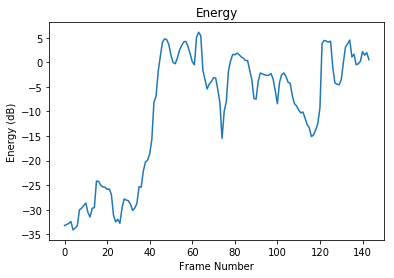

There were 144 frames
Spec: [[[[  2.09191092e-03   4.73936135e-03   3.19276354e-03 ...,
      1.80463656e-03   2.03923183e-03   1.71427755e-03]
   [  3.41014471e-03   3.57093010e-03   2.07785401e-03 ...,
      7.73009204e-04   5.19155117e-04   7.96810724e-04]
   [  5.58667071e-03   5.89139666e-03   4.71674791e-03 ...,
      7.68409693e-04   8.54306913e-04   2.06161058e-04]
   ..., 
   [  1.55576557e-01   2.20136821e-01   3.73912752e-01 ...,
      8.73601343e-03   1.10309722e-03   1.65126473e-03]
   [  9.73533541e-02   6.03774004e-02   1.96135998e-01 ...,
      6.60629477e-03   5.24699083e-03   3.81423905e-03]
   [  2.56388970e-02   2.06211150e-01   3.62698019e-01 ...,
      8.66541825e-03   3.74366273e-03   3.74844763e-03]]]]
Spec size: (1, 1, 144, 257)


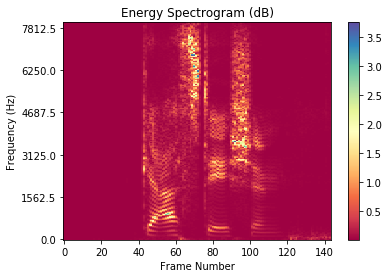

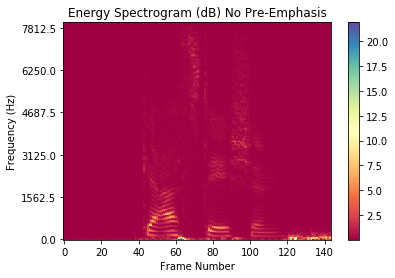

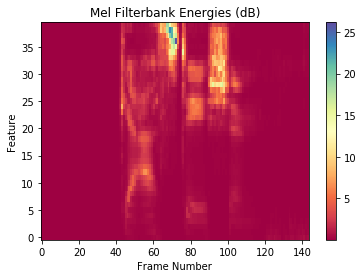

In [115]:
import tensorflow as tf
import matplotlib.pyplot as plt

def make_graph(sample_rate, frame_length_ms, frame_shift_ms, channels=1, filterbank_size=40, preemphasis=0.97, max_length=None, N_fft=512):
    ms_per_sec = 1000
    def constantify(x, name="constant"):
        return x, tf.constant(x, name=name)
    def variableify(x, name="variable"):
        return x, tf.Variable(x, name=name, trainable=False)
    def convert_ms_to_samples(ms, name="ms_to_samples"):
        x = np.int32(float(ms) / float(ms_per_sec) * float(sample_rate))
        return constantify(x, name)
    frame_length_py, frame_length = convert_ms_to_samples(frame_length_ms, name="frame_length")
    frame_shift_py, frame_shift = convert_ms_to_samples(frame_shift_ms, name="frame_shift")
    sample_rate_py, sample_rate = constantify(sample_rate, name="sample_rate")
    frame_length_ms_py, frame_length_ms = constantify(frame_length_ms, name="frame_length_ms")
    frame_shift_ms_py, frame_shift_ms = constantify(frame_shift_ms, name="frame_shift_ms")
    ms_per_sec_py, ms_per_sec = constantify(ms_per_sec, name="ms_per_sec")
    channels, channels_py = constantify(channels, name="channels")
    preemphasis, preemphasis_py = variableify(preemphasis, name="preemphasis")
    
    raw_waveforms = tf.placeholder(tf.float32, [None, channels, max_length], name="raw_waveforms")
    raw_waveform_lengths = tf.placeholder(tf.int32, [None], name="raw_waveform_lengths")
    with tf.name_scope("remove_offset"):
        dc_off = tf.reduce_mean(raw_waveforms, axis=2, name="dc_offset")
        s_of = tf.identity(raw_waveforms - dc_off, name="s_of")
    with tf.name_scope("preemphasis"):
        s_of_shift = tf.concat([tf.slice(s_of, [0, 0, 1], [-1, -1, -1]), tf.zeros([tf.shape(s_of)[0], channels, 1])], axis=2)
        print(s_of_shift)
        s_pe = tf.identity(s_of - preemphasis * s_of_shift, name="s_pe")
    with tf.name_scope("padding"):
        padding = frame_length - tf.mod(raw_waveform_lengths - frame_length, frame_shift)
        padding = tf.where(tf.equal(padding, frame_length), 0 * padding, padding, name="padding")
        padded_waveform_lengths = tf.add(raw_waveform_lengths, padding, name="padded_waveform_lengths")
        frame_counts = tf.divide(padded_waveform_lengths - frame_length, frame_shift, name="frame_counts")
        max_padded_length = tf.reduce_max(padded_waveform_lengths, name="max_padded_length")
        total_padding = tf.identity(max_padded_length - tf.reduce_max(raw_waveform_lengths), name="total_padding")
    def pad_signal(signal, name="pad_signal"):
        with tf.name_scope(name):
            signal_padded = tf.pad(signal,
                tf.stack([
                    tf.stack([0, 0]),
                    tf.stack([0, 0]),
                    tf.stack([0, total_padding]),
                ]),
                name="signal_padded")
            windowed_frames = sliding_window(signal_padded, frame_length_py, frame_shift_py,
                max_number_frames=tf.reduce_max(frame_counts), name="windowed_frames")
            frame_energy = tf.maximum(
                np.float32(-50.0),
                tf.identity(
                    10.0 * tf.log(tf.reduce_sum(tf.square(windowed_frames), axis=[3])) / tf.log(10.0),
                    name="frame_energy"))
            return windowed_frames
    s_of_windowed = pad_signal(s_of, name="pad_s_of")
    s_pe_windowed = pad_signal(s_pe, name="pad_s_pe")
    print(s_of_windowed)
    print(s_pe_windowed)
    timeseries_to_spec(s_of_windowed, frame_length_py, window_type='hamming', N_fft=N_fft, zero_pad=True, gpu=False, name="spec_no_pe")
    _, _, energy_spec = timeseries_to_spec(s_pe_windowed, frame_length_py, window_type='hamming', N_fft=N_fft, zero_pad=True, gpu=False, name="spec")
    filterbank = tf.constant(mel_filterbank(N_fft, sample_rate_py, num_bands=filterbank_size).astype(np.float32), name="filterbank_matrix")
    apply_filterbank(energy_spec, filterbank, name="filterbank")
    
g = tf.Graph()
with g.as_default():
    make_graph(16000, 25.0, 10.0)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        out = sess.run({
            "dc_off": g.get_tensor_by_name("remove_offset/dc_offset:0"),
            "frame_length": g.get_tensor_by_name("frame_length:0"),
            "frame_shift": g.get_tensor_by_name("frame_shift:0"),
            "padding": g.get_tensor_by_name("padding/padding:0"),
            "padded_length": g.get_tensor_by_name("padding/padded_waveform_lengths:0"),
            "total_padding": g.get_tensor_by_name("padding/total_padding:0"),
            "frame_counts": g.get_tensor_by_name("padding/frame_counts:0"),
            "padded_s_of": g.get_tensor_by_name("pad_s_of/signal_padded:0"),
            "padded_s_pe": g.get_tensor_by_name("pad_s_pe/signal_padded:0"),
            "windowed_frames_s_of": g.get_tensor_by_name("pad_s_of/windowed_frames/windowed_frames:0"),
            "windowed_frames_s_pe": g.get_tensor_by_name("pad_s_pe/windowed_frames/windowed_frames:0"),
            "frame_energy_s_of": g.get_tensor_by_name("pad_s_of/frame_energy:0"),
            "frame_energy_s_pe": g.get_tensor_by_name("pad_s_pe/frame_energy:0"),
            "spec_no_pe": g.get_tensor_by_name("spec_no_pe/energy_spec:0"),
            "spec": g.get_tensor_by_name("spec/energy_spec:0"),
            "filterbank": g.get_tensor_by_name("filterbank/filterbank:0"),
        }, feed_dict={
            g.get_tensor_by_name("raw_waveforms:0"): np.stack([np.stack([s_in])]),
            g.get_tensor_by_name("raw_waveform_lengths:0"): np.stack([s_in.shape[0]]).astype(np.int64),
        })
        print("The DC offset was: %(dc_off).4e" % out)
        print("The frame length was: %(frame_length)d" % out)
        print("The frame shift was: %(frame_shift)d" % out)
        print("The padding was: %(padding)d" % out)
        print("The total padding was: %(total_padding)s" % out)
        print("There were %(frame_counts)d frames" % out)
        print("The padded length was %(padded_length)d samples" % out)
        print("The padded audio was %(padded_s_of)s" % out)
        print("The padded audio was %(padded_s_pe)s" % out)
        print("The framed audio was %(windowed_frames_s_of)s" % out)
        print("The framed audio was %(windowed_frames_s_pe)s" % out)
        print("The framed audio energy for the 50th frame was %.4e" % out["frame_energy_s_of"][0, 0, 49])
        print("The framed audio energy for the 50th frame was %.4e" % out["frame_energy_s_pe"][0, 0, 49])
        plt.title("Energy")
        plt.plot(range(int(out["frame_counts"][0])), out["frame_energy_s_of"][0, 0, :])
        plt.xlabel("Frame Number")
        plt.ylabel("Energy (dB)")
        plt.show()
        print("There were %d frames" % out["frame_energy_s_of"].shape[2])
        print("Spec: %(spec)s" % out)
        print("Spec size: %s" % str(out["spec"].shape))
        plot_spec(out["spec"], sample_rate=sample_rate, title="Energy Spectrogram (dB)")
        plt.show()
        plot_spec(out["spec_no_pe"], sample_rate=sample_rate, title="Energy Spectrogram (dB) No Pre-Emphasis")
        plt.show()
        plot_spec(out["filterbank"], title="Mel Filterbank Energies (dB)")
        plt.ylabel("Feature")
        plt.show()

In [ ]:
mel = scipy.io.loadmat("./scratch/lab1-resources/mel_filters.mat")["mel_filters"]

In [ ]:
print(mel[:25,0])
print(mel[:25,1])

In [ ]:
melrep = mel_filterbank(256, 16000)
print(melrep[:25,0])
print(melrep[:25,1])

In [ ]:
c = plt.imshow(mel, cmap="Spectral", interpolation='nearest', aspect='auto')
plt.colorbar(c)
plt.show()
c = plt.imshow(melrep, cmap="Spectral", interpolation='nearest', aspect='auto')
plt.colorbar(c)
plt.show()
c = plt.imshow(melrep - mel, cmap="Spectral", interpolation='nearest', aspect='auto')
plt.colorbar(c)
plt.show()